# 1) Load Images

Before we can begin, we need to load and convert our 28 x 28 pixel PNG images into a machine readable format.

In [141]:
# Import necessary packages
import os
import struct
import numpy as np
from PIL import Image
import torch

# Import helpers
import matplotlib.pyplot as plt

## Convert our Images and Create Labels

In [142]:
# Function to convert image to numpy array (grayscale or RGB)
def image_to_array(image_path):
    image = Image.open(image_path).convert('L')  # Convert to grayscale (L mode)
    return image

#write to idx3 for images and idx1 for labels
def write_idx(images, labels, output_image_file, output_label_file):
    # Write the images in IDX3 format
    with open(output_image_file, 'wb') as f:
        f.write(struct.pack(">I", 2051))  # Magic number for images (2051)
        
        # Number of images, rows, cols
        f.write(struct.pack(">I", len(images)))  # Number of images
        f.write(struct.pack(">I", 28))  # Rows and columns (28X28 image)
        f.write(struct.pack(">I", 28))
        
        for image in images:
            # Write each image as a flat byte array
            f.write(image.tobytes())
            
    # Write the labels in IDX3 format
    with open(output_label_file, 'wb') as f:
        # Magic number for labels
        f.write(struct.pack(">I", 2049))  # Magic number for labels (2049)
        
        # Number of labels
        f.write(struct.pack(">I", len(labels)))  # Number of labels
        
        for label in labels:
            # Write the label as a single byte
            f.write(struct.pack("B", label))

# Run our conversions for each image file
def convert(input_folder, output_image_file, output_label_file):
    images = []
    labels = []
    
    for filename in os.listdir(input_folder):
        if filename.endswith((".png", ".jpg", ".jpeg")):
            # get label from Group5.Digits.<label char>_##.png
            label = filename[14]
            
            # opena nd convert to greyscale
            image = image_to_array(os.path.join(input_folder, filename))
            
            # Add image as array and add the label
            images.append(np.array(image))
            labels.append(int(label))
            
    # Convert to numpy array
    images = np.array(images)
    labels = np.array(labels)
    print(images.shape)
     # Flatten images
    images = images.reshape(len(images), -1)
    
    # Write our new files for later usage
    write_idx(images, labels, output_image_file, output_label_file)

# File Paths
input_folder = "./image_files/digits/"
output_folder = "./train_data/"
output_image_file = os.path.join(output_folder, "Group5.Digits.Images.idx3-ubyte")
output_label_file = os.path.join(output_folder, "Group5.Digits.Labels.idx1-ubyte")

# Convert to IDX format
convert(input_folder, output_image_file, output_label_file)

(30, 28, 28)


## Visualize the Data

Just to show that everything works, we can now visualize the data from its IDX3 and IBX1 image and label formats.

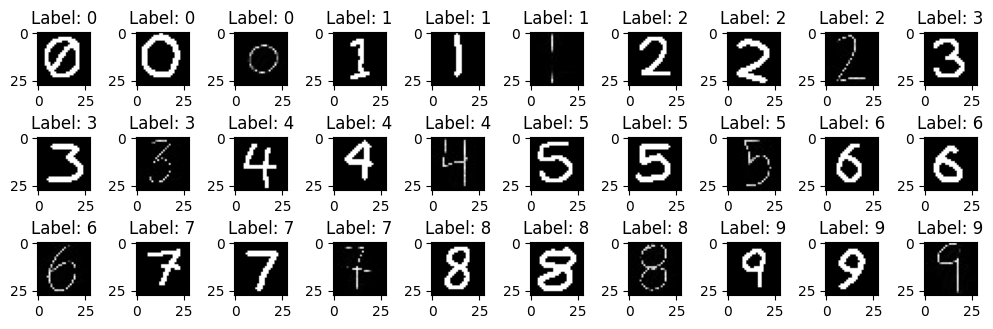

In [143]:
# Open the new idx3 file for images
def read_images(file_path):
    with open(file_path, 'rb') as f:
        magic, num_images, num_rows, num_cols = struct.unpack('>IIII', f.read(16))
        images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num_images, num_rows * num_cols)
    return images

# Open the new idx1 file for labels
def read_labels(file_path):
    with open(file_path, 'rb') as f:
        magic, num_labels = struct.unpack('>II', f.read(8))
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels

# Call our functions and store our images and labels
images = read_images('./train_data/Group5.Digits.Images.idx3-ubyte')
labels = read_labels('./train_data/Group5.Digits.Labels.idx1-ubyte')

# Create variables for display
num_images = len(images)
num_cols = 10
num_rows = (num_images + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, num_rows * 1.1))
axes = axes.flatten()  

# Print our plot of images and labels
for i in range(num_images):
    ax = axes[i]  
    image = images[i].reshape(28, 28)  
    ax.imshow(image, cmap='gray')  
    ax.set_title(f"Label: {labels[i]}")  

plt.tight_layout()
plt.show()

# Training our Neural Net

First, prepare training data.

In [144]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                              ])
# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
print (trainloader)

## Backpropogation

NOT SURE IF CORRECT

In [145]:
x = torch.randn(3,3, requires_grad=True)
print("x:", x)

y = x**2
print("y:", y)

## grad_fn shows the function that generated this variable
print("y.grad_fn:", y.grad_fn)

y.retain_grad()

z = y.mean()
print("z:", z)

z.backward()
print("x.grad:", x.grad)
print("2*x/9:", 2*x/9)
print("y.grad:", y.grad)

x: tensor([[-0.6109, -0.6544, -1.0523],
        [ 0.0332, -0.4013,  0.5612],
        [ 0.4992, -1.7720, -0.5546]], requires_grad=True)
y: tensor([[3.7322e-01, 4.2825e-01, 1.1074e+00],
        [1.1026e-03, 1.6104e-01, 3.1498e-01],
        [2.4917e-01, 3.1399e+00, 3.0763e-01]], grad_fn=<PowBackward0>)
y.grad_fn: <PowBackward0 object at 0x0000023F889E5A50>
z: tensor(0.6759, grad_fn=<MeanBackward0>)
x.grad: tensor([[-0.1358, -0.1454, -0.2339],
        [ 0.0074, -0.0892,  0.1247],
        [ 0.1109, -0.3938, -0.1233]])
2*x/9: tensor([[-0.1358, -0.1454, -0.2339],
        [ 0.0074, -0.0892,  0.1247],
        [ 0.1109, -0.3938, -0.1233]], grad_fn=<DivBackward0>)
y.grad: tensor([[0.1111, 0.1111, 0.1111],
        [0.1111, 0.1111, 0.1111],
        [0.1111, 0.1111, 0.1111]])


## Loss and Autograd together

In [146]:
# Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 128), # Flattened MNIST image sizes (28x28) & Linear layer maps
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10), # 10 output layers for each digit
                      nn.LogSoftmax(dim=1))  # this line is extra comparing to earlier nn.Sequential calls

criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logits = model(images)
loss = criterion(logits, labels)

print('Before backward pass: \n', model[0].weight.grad)

loss.backward()

print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[ 0.0037,  0.0037,  0.0037,  ...,  0.0037,  0.0037,  0.0037],
        [-0.0025, -0.0025, -0.0025,  ..., -0.0025, -0.0025, -0.0025],
        [ 0.0025,  0.0025,  0.0025,  ...,  0.0025,  0.0025,  0.0025],
        ...,
        [-0.0011, -0.0011, -0.0011,  ..., -0.0011, -0.0011, -0.0011],
        [-0.0005, -0.0005, -0.0005,  ..., -0.0005, -0.0005, -0.0005],
        [-0.0006, -0.0006, -0.0006,  ..., -0.0006, -0.0006, -0.0006]])


## Training the network!

In [147]:
from torch import optim

# Optimizers require the parameters to optimize and a learning rate
optimizer = optim.SGD(model.parameters(), lr=0.01)
print(model.parameters())
for parameter in model.parameters():
    print(parameter.shape)

<generator object Module.parameters at 0x0000023F8A20DA80>
torch.Size([128, 784])
torch.Size([128])
torch.Size([64, 128])
torch.Size([64])
torch.Size([10, 64])
torch.Size([10])


In [148]:
print('Initial weights - ', model[0].weight)

images, labels = next(iter(trainloader))
images.resize_(64, 784) # another way to flatten

# Clear the gradients, do this because gradients are accumulated
optimizer.zero_grad()

# Forward pass, then backward pass, then update weights
output = model(images)
loss = criterion(output, labels)
loss.backward()
print('Gradient -', model[0].weight.grad)

# Take an update step and few the new weights
optimizer.step()
print('Updated weights - ', model[0].weight)

Initial weights -  Parameter containing:
tensor([[ 0.0236,  0.0214,  0.0048,  ..., -0.0107,  0.0234,  0.0262],
        [ 0.0227, -0.0341,  0.0283,  ...,  0.0105, -0.0010,  0.0048],
        [ 0.0272,  0.0223, -0.0101,  ...,  0.0285,  0.0085,  0.0299],
        ...,
        [-0.0069,  0.0114,  0.0212,  ...,  0.0039, -0.0068,  0.0085],
        [ 0.0285, -0.0148, -0.0017,  ..., -0.0320,  0.0116,  0.0309],
        [ 0.0081, -0.0122, -0.0266,  ..., -0.0222,  0.0356, -0.0163]],
       requires_grad=True)
Gradient - tensor([[ 0.0026,  0.0026,  0.0026,  ...,  0.0026,  0.0026,  0.0026],
        [-0.0005, -0.0005, -0.0005,  ..., -0.0005, -0.0005, -0.0005],
        [ 0.0014,  0.0014,  0.0014,  ...,  0.0014,  0.0014,  0.0014],
        ...,
        [-0.0013, -0.0013, -0.0013,  ..., -0.0013, -0.0013, -0.0013],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0011,  0.0011,  0.0011,  ...,  0.0011,  0.0011,  0.0011]])
Updated weights -  Parameter containing:
tensor([[ 0.

### Training for real

Now we'll put this algorithm into a loop so we can go through all the images. Some nomenclature, one pass through the entire dataset is called an *epoch*. So here we're going to loop through `trainloader` to get our training batches. For each batch, we'll doing a training pass where we calculate the loss, do a backwards pass, and update the weights.

>**Final Project:** This is the training pass for our network. If implemented correctly, you should see the training loss drop with each epoch.

1. Training Pass, calculate loss
2. Backwards Pass
3. Update Weights

In [149]:
epochs = 5 # Number of training cycles
losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    epoch_losses = []
    for images, labels in trainloader:
        images = images.view(images.size(0), -1) # Flatten our images to 784 (28x28)

        # Zero out the gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(images)

        # Calculate loss
        loss = criterion(output, labels)
        
        # Backward pass
        loss.backward()
        
        # Update weights
        optimizer.step()

        running_loss += loss.item()
        epoch_losses.append(loss.item())

    losses.append(epoch_losses)
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(trainloader):.4f}")
    
print("Training complete!")

Epoch 1/5, Loss: 1.0306
Epoch 2/5, Loss: 0.3790
Epoch 3/5, Loss: 0.3194
Epoch 4/5, Loss: 0.2889
Epoch 5/5, Loss: 0.2647
Training complete!


Length of trainloader:938


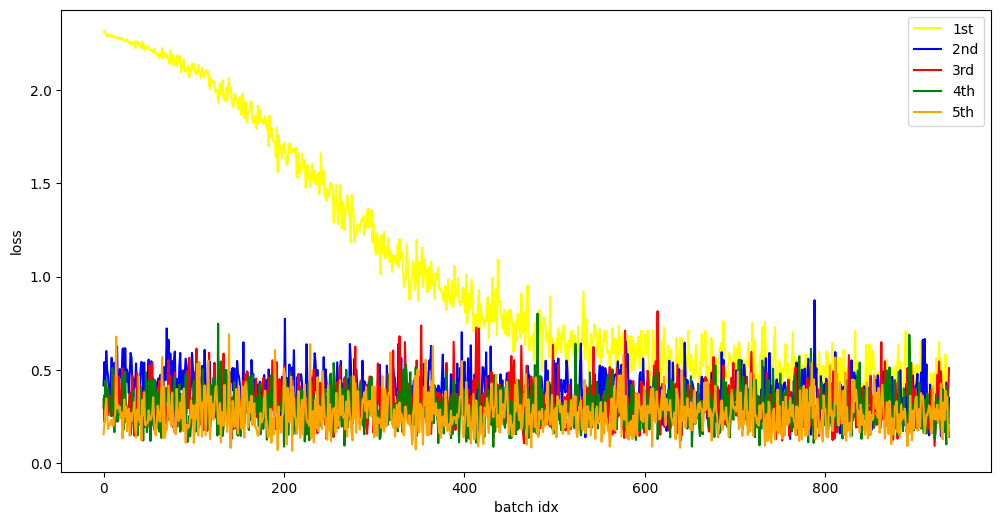

In [150]:
x = np.arange(len(trainloader))

print (f"Length of trainloader:{len(trainloader)}")

nplosses = np.array(losses)

plt.figure(figsize=[12, 6])
plt.plot(x, losses[0], color='yellow', label="1st")
plt.plot(x, losses[1], color='b', label="2nd")
plt.plot(x, losses[2], color='r', label="3rd")
plt.plot(x, losses[3], color='g', label="4th")
plt.plot(x, losses[4], color='orange', label="5th")
plt.xlabel('batch idx')
plt.ylabel('loss')
plt.legend()
plt.show()

# Put it all together!

Epoch 1/5, Loss: 0.3331
Epoch 2/5, Loss: 0.1927
Epoch 3/5, Loss: 0.1550
Epoch 4/5, Loss: 0.1379
Epoch 5/5, Loss: 0.1301
Training complete!
Length of trainloader:938


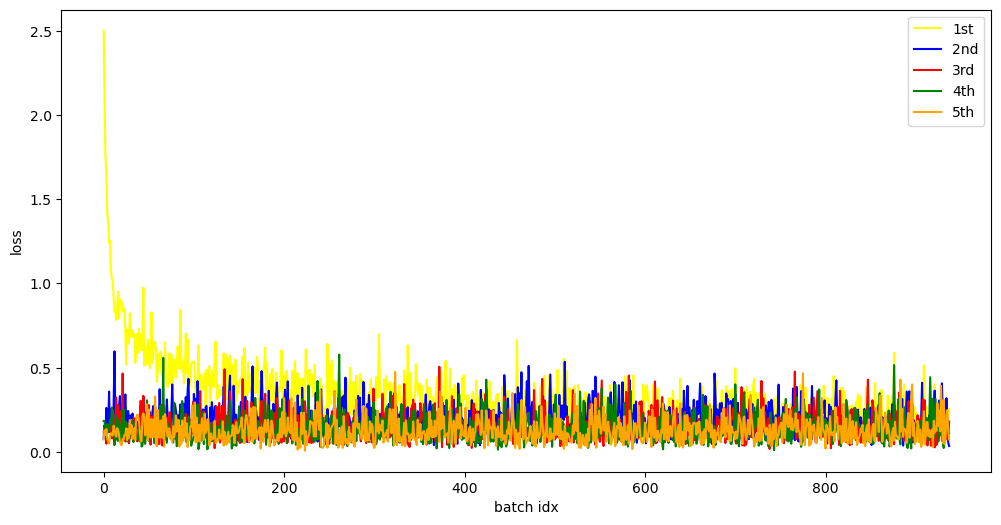

In [227]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch import optim

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                              ])
# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)



## Loss and Autograd model
# Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 128),   # Flattened MNIST image sizes (28x28) & Linear layer maps
                      nn.ELU(),              # Activation function
                      nn.BatchNorm1d(128),   # Normalize our batch for stability
                      nn.Dropout(0.2),       # Prevent overfitting
                      nn.Linear(128, 64),
                      nn.ELU(),
                      nn.BatchNorm1d(64),
                      nn.Dropout(0.2),
                      nn.Linear(64, 10),     # 10 output layers for each digit
                      nn.LogSoftmax(dim=1))  # this line is extra comparing to earlier nn.Sequential calls

# Check if we can run this on a GPU, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


## Loss function
criterion = nn.NLLLoss()



## Training Loop
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 5 # Number of training cycles
losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    epoch_losses = []
    for images, labels in trainloader:
        images = images.view(images.size(0), -1) # Flatten our images to 784 (28x28)

        # Zero out the gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(images)

        # Calculate loss
        loss = criterion(output, labels)
        
        # Backward pass
        loss.backward()
        
        # Update weights
        optimizer.step()

        running_loss += loss.item()
        epoch_losses.append(loss.item())

    losses.append(epoch_losses)
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(trainloader):.4f}")
    
print("Training complete!")



## Print the visuals
x = np.arange(len(trainloader))

print (f"Length of trainloader:{len(trainloader)}")

nplosses = np.array(losses)

plt.figure(figsize=[12, 6])
plt.plot(x, losses[0], color='yellow', label="1st")
plt.plot(x, losses[1], color='b', label="2nd")
plt.plot(x, losses[2], color='r', label="3rd")
plt.plot(x, losses[3], color='g', label="4th")
plt.plot(x, losses[4], color='orange', label="5th")
plt.xlabel('batch idx')
plt.ylabel('loss')
plt.legend()
plt.show()

In [231]:
# File Paths
input_folder = "./digits/"
output_folder = "./test_data/"
output_image_file = os.path.join(output_folder, "Class.Digits.Images.idx3-ubyte")
output_label_file = os.path.join(output_folder, "Class.Digits.Labels.idx1-ubyte")

images = []
labels = []

for filename in os.listdir(input_folder):
    if filename.endswith((".png", ".jpg", ".jpeg")):
        # get label from Group5.Digits.<label char>_##.png
        label = filename[0]
        
        # opena nd convert to greyscale
        image = Image.open(os.path.join(input_folder, filename)).convert('L')
        if image.size != (28, 28):
            print(f"Image {filename} is not 28x28, it has shape {image.size}")
            print(f"Group {filename[2]}, shame on you!")
            image = image.resize((28, 28))
        image = np.array(image)
        # Add image as array and add the label
        images.append(image)
        labels.append(int(label))

# Convert to numpy array
images = np.array(images)
labels = np.array(labels)

# Flatten images
images = images.reshape(len(images), -1)

# Write our new files for later usage
write_idx(images, labels, output_image_file, output_label_file)

Image 0-3-4.png is not 28x28, it has shape (28, 26)
Group 3, shame on you!
Image 2-3-4.png is not 28x28, it has shape (28, 26)
Group 3, shame on you!
Image 5-3-4.png is not 28x28, it has shape (29, 28)
Group 3, shame on you!
Image 6-3-4.png is not 28x28, it has shape (29, 28)
Group 3, shame on you!
Image 8-3-4.png is not 28x28, it has shape (29, 28)
Group 3, shame on you!


# Prediction testing with our custom images

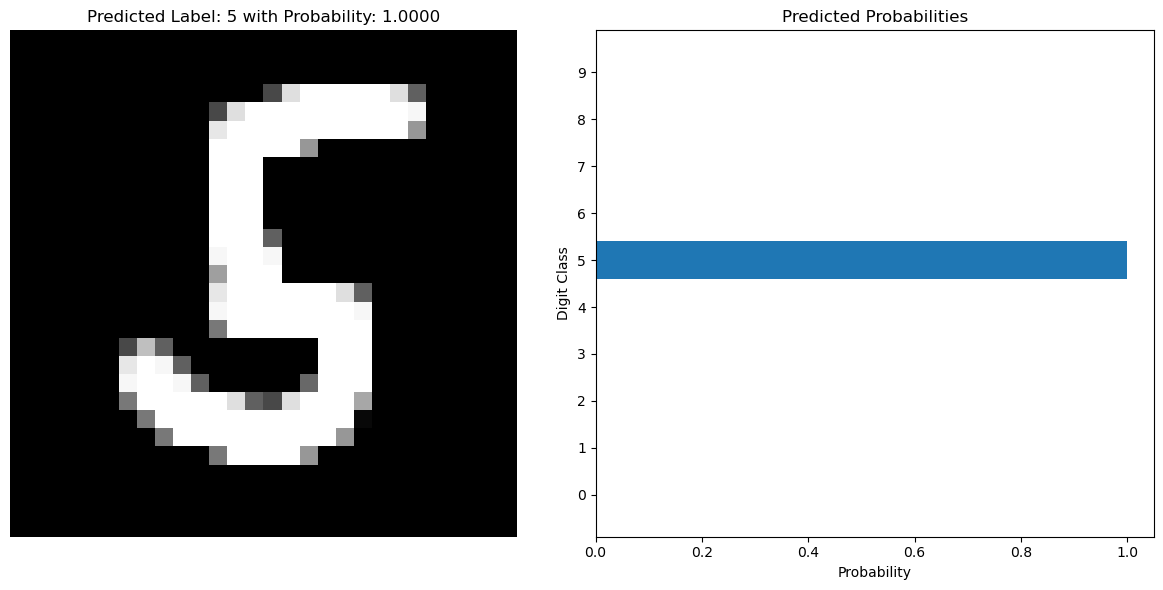

In [239]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
%matplotlib inline
import helper

model.eval()

# Using the numpy arrays fromn the previous block,
# Convert the images and labels into tensors
if isinstance(images, torch.Tensor):
    images_tensor = images.clone().detach().float()
else:
    images_tensor = torch.tensor(images, dtype=torch.float32)
    
if isinstance(labels, torch.Tensor):
    labels_tensor = labels.clone().detach().long()
else:
    labels_tensor = torch.tensor(labels, dtype=torch.long)


# Create a dataset
dataset = TensorDataset(images_tensor, labels_tensor)

# Create the dataloader
testLoader = DataLoader(dataset, batch_size=64, shuffle=True)



# we are just using an image from trainloader, in the future we'll use frorm testloader
images, labels = next(iter(testLoader))

img = images[33].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    # the block of code with gradient turned off
    # here is for detection, so just do the following to compute the forward prediction.
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)

# Turn the tensor into a numpy array for visualization
img = img.view(28, 28).numpy()

# Get the predicted class
prob, class_idx = ps.topk(1, dim=1)
label = class_idx.item()

# Plot the image and the probabilities
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

# Plot image
ax1.imshow(img, cmap='gray')
ax1.set_title(f"Predicted Label: {label} with Probability: {prob.item():.4f}")
ax1.axis('off')

# Plot probabilities
ax2.barh(np.arange(10), ps.squeeze().numpy())
ax2.set_yticks(np.arange(10))
ax2.set_yticklabels(np.arange(10))  # Set y-tick labels to digits 0-9
ax2.set_xlabel('Probability')
ax2.set_ylabel('Digit Class')
ax2.set_title('Predicted Probabilities')

plt.tight_layout()
plt.show()

### Train on class dataset to improve
Train on the class dataset to increase accuracy
(Note, must rerun the data loading part every time you want to rerun this):

torch.Size([64, 784])
torch.Size([64])
Epoch 1/5, Loss: 0.0753
Epoch 2/5, Loss: 0.0537
Epoch 3/5, Loss: 0.0574
Epoch 4/5, Loss: 0.0249
Epoch 5/5, Loss: 0.0462
Training complete!
Length of trainloader:1


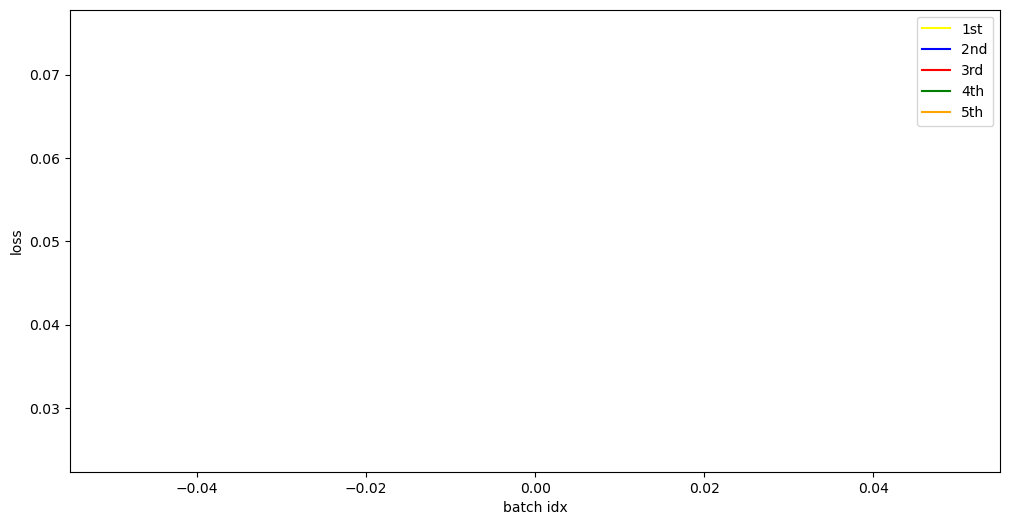

In [240]:
model.train()

# Training Loop
from torch.utils.data import DataLoader, TensorDataset

batch_size = 64 #set to what is used in model
epochs = 5 # Number of training cycles
losses = []

print(images.shape)
print(labels.shape)

#Load our images from numpy into tensors, then load them into a dataset and use a dataloader
images = images_tensor # Shape: (500, 784)
labels = labels_tensor  # Shape: (500,)

dataset = TensorDataset(images, labels)
trainloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    epoch_losses = []
    for images, labels in trainloader:
        
        # Zero out the gradients
        optimizer.zero_grad()
        
        # Forward pass
        output = model(images)

        # Calculate loss
        loss = criterion(output, labels)
        
        # Backward pass
        loss.backward()
        
        # Update weights
        optimizer.step()

        running_loss += loss.item()
        epoch_losses.append(loss.item())

    losses.append(epoch_losses)
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(trainloader):.4f}")
    
print("Training complete!")



## Print the visuals
x = np.arange(len(trainloader))

print (f"Length of trainloader:{len(trainloader)}")

nplosses = np.array(losses)

plt.figure(figsize=[12, 6])
plt.plot(x, losses[0], color='yellow', label="1st")
plt.plot(x, losses[1], color='b', label="2nd")
plt.plot(x, losses[2], color='r', label="3rd")
plt.plot(x, losses[3], color='g', label="4th")
plt.plot(x, losses[4], color='orange', label="5th")
plt.xlabel('batch idx')
plt.ylabel('loss')
plt.legend()
plt.show()